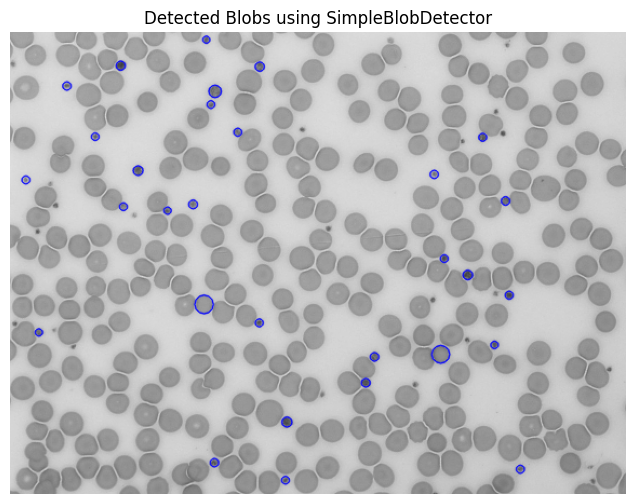

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = "platelets.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 30
params.maxArea = 250

params.filterByCircularity = True
params.minCircularity = 0.2


params.filterByConvexity = True
params.minConvexity = 0.7


params.filterByInertia = True
params.minInertiaRatio = 0.2


detector = cv2.SimpleBlobDetector_create(params)


keypoints = detector.detect(image)


image_with_blobs = cv2.drawKeypoints(
    image, keypoints, np.array([]), (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)


plt.figure(figsize=(10, 6))
plt.imshow(image_with_blobs, cmap='gray')
plt.title("Detected Blobs using SimpleBlobDetector")
plt.axis("off")
plt.show()

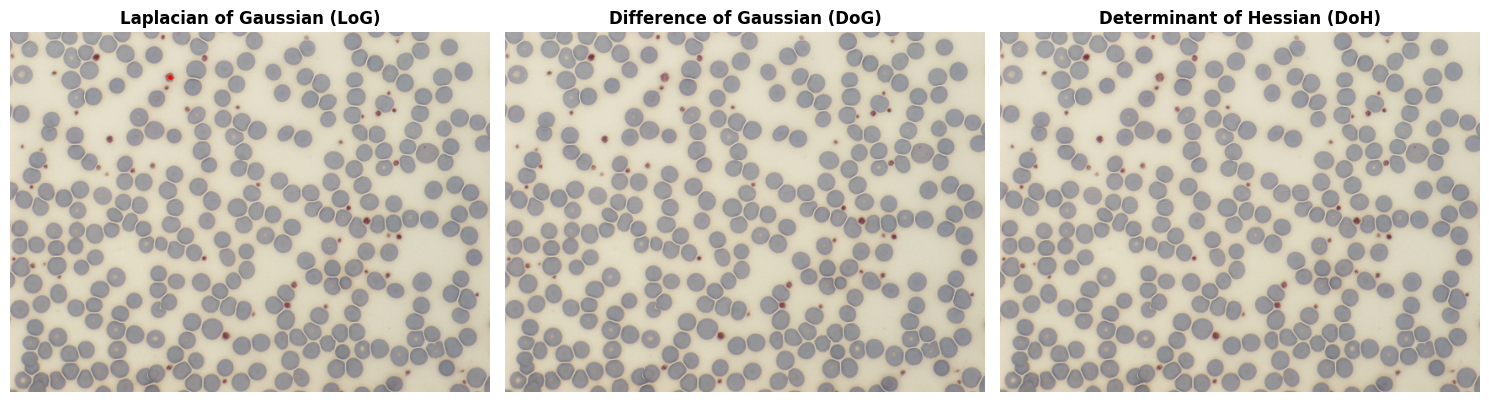

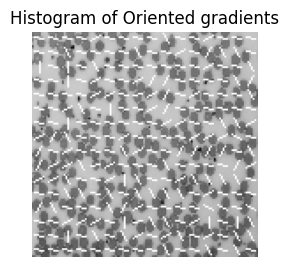

In [29]:
from skimage.feature import blob_log, blob_dog, blob_doh, hog
from skimage import img_as_float


image_path = "platelets.png"
image_color = cv2.imread(image_path)
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
image_float = img_as_float(image_gray)


image_hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)


lower_purple = np.array([120, 50, 50])
upper_purple = np.array([160, 255, 255])


mask_purple = cv2.inRange(image_hsv, lower_purple, upper_purple)


blobs_log = blob_log(image_float, min_sigma=1, max_sigma=3, num_sigma=3, threshold=0.02, overlap=0.1)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2) 


blobs_dog = blob_dog(image_float, min_sigma=1, max_sigma=3, sigma_ratio=1.6, threshold=0.02, overlap=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)


blobs_doh = blob_doh(image_float, min_sigma=1, max_sigma=3, num_sigma=3, threshold=0.01, overlap=0.1)


def filter_blobs(blobs):
    return np.array([blob for blob in blobs if mask_purple[int(blob[0]), int(blob[1])] > 0])


filtered_log = filter_blobs(blobs_log)
filtered_dog = filter_blobs(blobs_dog)
filtered_doh = filter_blobs(blobs_doh)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Laplacian of Gaussian (LoG)", "Difference of Gaussian (DoG)", "Determinant of Hessian (DoH)"]
blobs_list = [filtered_log, filtered_dog, filtered_doh]

for ax, title, blobs in zip(axes, titles, blobs_list):
    ax.imshow(image_color, cmap='gray')
    for y, x, r in blobs:
        ax.add_patch(plt.Circle((x, y), r, color='red', linewidth=1.5, fill=False))
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis("off")

plt.tight_layout()
plt.show()

import numpy as np
import cv2
from matplotlib import pyplot as plt

def compute_hog(image, cell_size=(8, 8), block_size=(2, 2), bins=9):
    """
    Compute Histogram of Oriented Gradients for an image
    
    Parameters:
    - image: Input image (grayscale)
    - cell_size: Size of each cell (height, width)
    - block_size: Size of each block in cells (height, width)
    - bins: Number of orientation bins
    
    Returns:
    - hog_features: HOG features
    - hog_image: Visualization of HOG
    """
    
    # 1. Compute gradients
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=1)
    
    # Compute magnitude and orientation
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180
    
    # 2. Divide image into cells
    cell_height, cell_width = cell_size
    h, w = image.shape
    n_cells_y = h // cell_height
    n_cells_x = w // cell_width
    
    # Initialize histograms for cells
    histograms = np.zeros((n_cells_y, n_cells_x, bins))
    
    # Compute histogram for each cell
    for y in range(n_cells_y):
        for x in range(n_cells_x):
            # Get current cell
            cell_mag = magnitude[y*cell_height:(y+1)*cell_height, 
                               x*cell_width:(x+1)*cell_width]
            cell_ori = orientation[y*cell_height:(y+1)*cell_height, 
                                 x*cell_width:(x+1)*cell_width]
            
            # Compute histogram for current cell
            for i in range(cell_height):
                for j in range(cell_width):
                    ori = cell_ori[i, j]
                    mag = cell_mag[i, j]
                    
                    # Interpolate between bins
                    bin_index = int(ori // (180 / bins))
                    bin_decimal = ori % (180 / bins) / (180 / bins)
                    
                    if bin_index == bins - 1:
                        histograms[y, x, bin_index] += mag * (1 - bin_decimal)
                        histograms[y, x, 0] += mag * bin_decimal
                    else:
                        histograms[y, x, bin_index] += mag * (1 - bin_decimal)
                        histograms[y, x, bin_index + 1] += mag * bin_decimal
    
    # 3. Block normalization
    block_height, block_width = block_size
    n_blocks_y = n_cells_y - block_height + 1
    n_blocks_x = n_cells_x - block_width + 1
    
    normalized_blocks = []
    
    for y in range(n_blocks_y):
        for x in range(n_blocks_x):
            block = histograms[y:y+block_height, x:x+block_width, :]
            block_flat = block.flatten()
            
            # L2 normalization
            norm = np.sqrt(np.sum(block_flat**2) + 1e-6)
            normalized_blocks.append(block_flat / norm)
    
    hog_features = np.concatenate(normalized_blocks)
    
    # Create visualization
    cell_gradients = np.zeros((n_cells_y, n_cells_x, cell_height, cell_width))
    for y in range(n_cells_y):
        for x in range(n_cells_x):
            cell_hist = histograms[y, x, :]
            max_bin = np.argmax(cell_hist)
            orientation_center = max_bin * (180 / bins) + (180 / bins) / 2
            
            # Create line for visualization
            radius = min(cell_height, cell_width) // 2 - 1
            center_y = y * cell_height + cell_height // 2
            center_x = x * cell_width + cell_width // 2
            
            y1 = int(center_y - radius * np.sin(orientation_center * np.pi / 180))
            x1 = int(center_x - radius * np.cos(orientation_center * np.pi / 180))
            y2 = int(center_y + radius * np.sin(orientation_center * np.pi / 180))
            x2 = int(center_x + radius * np.cos(orientation_center * np.pi / 180))
            
            # Draw the line
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 1)
    
    return hog_features, image

img = cv2.imread('platelets.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))  # Resize to standard size
hog_features, hog_image = compute_hog(img.copy())

# # Visualize
# plt.figure(figsize=(12, 4))
# plt.subplot(121)
# plt.imshow(img, cmap='gray')
# plt.title('Original Image')
# plt.axis('off')

plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('Histogram of Oriented gradients')
plt.axis('off')
plt.show()
# fd, hog_image = hog(image_path, orientations=8, pixels_per_cell=(16, 16),
#                     cells_per_block=(1, 1), visualize=True)

# plt.imshow(hog_image, cmap='gray')
# plt.title("Histogram of Oriented Gradients (HoG)")
# plt.axis("off")
# plt.show()

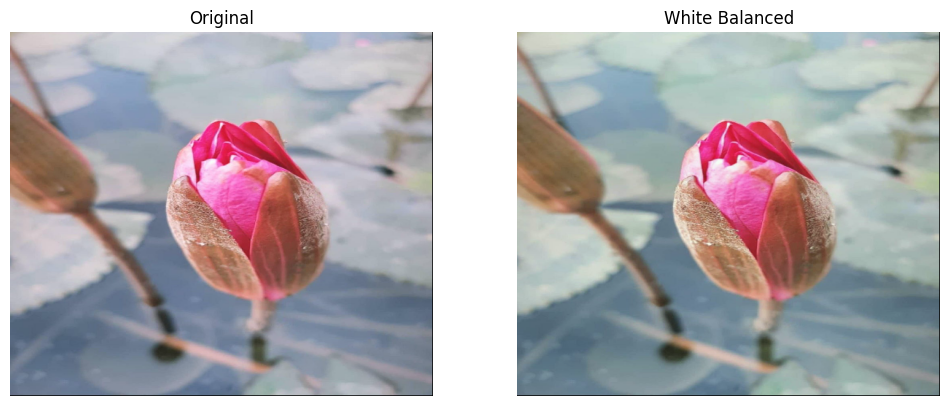

In [30]:

from skimage.exposure import equalize_hist

filepath = "flower.png"
# Load Image
def load_image(filepath):
    with open(filepath, 'rb') as f:
        img = cv2.imdecode(np.frombuffer(f.read(), np.uint8), cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def adjust_brightness_contrast(image, alpha=1.2, beta=20):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def remove_noise(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def enhance_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def resize_image(image, width, height):
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

def inverse_transform(image):
    return 255 - image

def histogram_equalization(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return equalize_hist(gray)

def super_resolution(image):
    upscaled = cv2.pyrUp(image)
    return cv2.pyrDown(upscaled)

# def color_correction(image):
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     lower = np.array([0, 0, 0])
#     upper = np.array([255, 255, 255])
#     mask = cv2.inRange(hsv, lower, upper)
#     return cv2.bitwise_and(image, image, mask=mask)
import cv2
import numpy as np
import matplotlib.pyplot as plt

def white_balance_gray_world(img):
    """
    Apply white balancing using the Gray World Assumption.
    """
    # Convert to float32 for precision
    img = img.astype(np.float32)

    # Calculate mean of each channel
    avg_b = np.mean(img[:, :, 0])
    avg_g = np.mean(img[:, :, 1])
    avg_r = np.mean(img[:, :, 2])

    # Overall average
    avg_gray = (avg_r + avg_g + avg_b) / 3

    # Scale each channel
    img[:, :, 0] *= (avg_gray / avg_b)
    img[:, :, 1] *= (avg_gray / avg_g)
    img[:, :, 2] *= (avg_gray / avg_r)

    # Clip and convert back to uint8
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img


# Example Usage
if __name__ == "__main__":
    img_path = "flower.png"
    image = load_image(img_path)

    bright_contrast = adjust_brightness_contrast(image)
    sharpened = sharpen_image(image)
    noise_removed = remove_noise(image)
    color_enhanced = enhance_color(image)
    resized = resize_image(image, 300, 300)
    inverse = inverse_transform(image)
    hist_eq = histogram_equalization(image)
    super_res = super_resolution(image)
    # color_corrected = color_correction(image)
    # Load an image
image = cv2.imread("flower.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Apply white balance
balanced_img = white_balance_gray_world(image)

# Show results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("White Balanced")
plt.imshow(balanced_img)
plt.axis('off')

plt.show()




In [31]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import time
# from torchvision.models import vgg16, alexnet
# from torch.utils.data import DataLoader, Subset
# import numpy as np

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Transform
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Load CIFAR-100
# full_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# full_test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# # Create smaller subsets (e.g., 10% of data)
# subset_ratio = 0.1
# train_indices = np.random.choice(len(full_train_dataset), int(len(full_train_dataset) * subset_ratio), replace=False)
# test_indices = np.random.choice(len(full_test_dataset), int(len(full_test_dataset) * subset_ratio), replace=False)

# train_dataset = Subset(full_train_dataset, train_indices)
# test_dataset = Subset(full_test_dataset, test_indices)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# # Load models
# def get_model(model_name):
#     if model_name == "alexnet":
#         model = alexnet(pretrained=True)
#         model.classifier[6] = nn.Linear(4096, 100)
#     elif model_name == "vgg16":
#         model = vgg16(pretrained=True)
#         model.classifier[6] = nn.Linear(4096, 100)
#     return model.to(device)

# # Training function
# def train_model(model, train_loader, criterion, optimizer, epochs=3):  # fewer epochs
#     model.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# # Evaluation function
# def evaluate_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     start_time = time.time()
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     end_time = time.time()
#     accuracy = 100 * correct / total
#     print(f"Accuracy: {accuracy:.2f}%, Inference Time: {end_time - start_time:.2f}s")
#     return accuracy, end_time - start_time

# # Train & evaluate AlexNet
# alexnet_model = get_model("alexnet")
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(alexnet_model.parameters(), lr=0.001)
# train_model(alexnet_model, train_loader, criterion, optimizer, epochs=3)
# alexnet_acc, alexnet_time = evaluate_model(alexnet_model, test_loader)

# # Train & evaluate VGG16
# vgg16_model = get_model("vgg16")
# optimizer = optim.Adam(vgg16_model.parameters(), lr=0.001)
# train_model(vgg16_model, train_loader, criterion, optimizer, epochs=3)
# vgg16_acc, vgg16_time = evaluate_model(vgg16_model, test_loader)

# # Compare results
# print(f"AlexNet - Accuracy: {alexnet_acc:.2f}%, Time: {alexnet_time:.2f}s")
# print(f"VGG16 - Accuracy: {vgg16_acc:.2f}%, Time: {vgg16_time:.2f}s")
